In [172]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [173]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [174]:
tf.__version__

'2.1.0'

In [175]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [176]:
#segment_speeds = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/segment-data/5min-intervals/226255131.csv", sep=";")
#segment_speeds = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/segment-data/30-min-intervals/226255131.csv", sep=";")
segment_speeds = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/segment-data/60-min-intervals/226255131.csv", sep=";")

In [177]:
pd.to_datetime(segment_speeds['StartTime'], format="%Y-%m-%d %H:%M:%S")

0       2019-06-03 00:00:00
1       2019-06-03 01:00:00
2       2019-06-03 02:00:00
3       2019-06-03 03:00:00
4       2019-06-03 04:00:00
                ...        
21571   2021-11-22 19:00:00
21572   2021-11-22 20:00:00
21573   2021-11-22 21:00:00
21574   2021-11-22 22:00:00
21575   2021-11-22 23:00:00
Name: StartTime, Length: 21576, dtype: datetime64[ns]

In [178]:
segment_speeds['hour'] = pd.DatetimeIndex(segment_speeds['StartTime']).hour

In [179]:
segment_speeds['day'] = pd.DatetimeIndex(segment_speeds['StartTime']).dayofyear

In [180]:
segment_speeds.head(5)

,SegmentId,StartTime,EndTime,Speed,hour,day
0,226255131,2019-06-03 00:00:00,2019-06-03 01:00:00,NaN,0,154
1,226255131,2019-06-03 01:00:00,2019-06-03 02:00:00,NaN,1,154
2,226255131,2019-06-03 02:00:00,2019-06-03 03:00:00,NaN,2,154
3,226255131,2019-06-03 03:00:00,2019-06-03 04:00:00,NaN,3,154
4,226255131,2019-06-03 04:00:00,2019-06-03 05:00:00,NaN,4,154


In [181]:
segment_speeds = segment_speeds[24:]

In [182]:
segment_speeds.head(5)

,SegmentId,StartTime,EndTime,Speed,hour,day
24,226255131,2019-06-04 00:00:00,2019-06-04 01:00:00,91.383333,0,155
25,226255131,2019-06-04 01:00:00,2019-06-04 02:00:00,92.000000,1,155
26,226255131,2019-06-04 02:00:00,2019-06-04 03:00:00,93.666667,2,155
27,226255131,2019-06-04 03:00:00,2019-06-04 04:00:00,86.216667,3,155
28,226255131,2019-06-04 04:00:00,2019-06-04 05:00:00,90.116667,4,155


<AxesSubplot:>

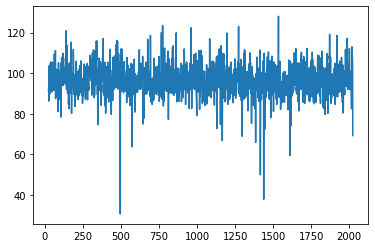

In [183]:
segment_speeds['Speed'][0:2000].plot()

In [184]:
pd.isnull(segment_speeds).values.sum()

146

In [185]:
segment_speeds = segment_speeds.interpolate(method='linear', limit_direction='forward', axis=0)

In [186]:
#segment_speeds.dropna(inplace=True)

In [187]:
pd.isnull(segment_speeds).values.sum()

0

We know these missing values are the first ones in the data set because we can't do interpolation if we don't have a p1 and p2 to make a line of interpolated values

In [188]:
target_names = ['Speed']

We can see all of these anormalities which are things we most likely wont be able to predict as good enough by not including the event data

In [189]:
# Normally we would want to have 48 shift_steps here because 30min = 0.5h and then 0.5*48 = 24 which would cover each day.
# but in our data there are no measurements from 00:00 to 08:00 so we dropped those. This means we get shift step of 
# 16h => 32 of 30min steps

shift_steps_of_5_min = 4

In [190]:
segment_speeds_targets = segment_speeds[['Speed']].shift(-shift_steps_of_5_min)

In [191]:
segment_speeds_targets.head(25)

,Speed
24,90.116667
25,103.627119
26,92.666667
27,101.366667
28,98.616667
29,93.083333
30,92.200000
31,89.898305
32,93.900000
33,104.850000


In [192]:
x_data = segment_speeds[['Speed', 'hour', 'day']].values[0:-shift_steps_of_5_min]

In [193]:
x_data.shape

(21548, 3)

In [194]:
y_data = segment_speeds_targets.values[:-shift_steps_of_5_min]

In [195]:
y_data.shape

(21548, 1)

In [196]:
num_data = len(x_data)
num_data

21548

In [197]:
train_split = 0.9

In [198]:
num_train = int(train_split * num_data)
num_train

19393

In [199]:
num_test = num_data - num_train
num_test

2155

In [200]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

21548

In [201]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

21548

In [202]:
num_x_signals = x_data.shape[1]
num_x_signals

3

In [203]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [204]:
print("Min:", np.min(segment_speeds['Speed']))
print("Max:", np.max(segment_speeds['Speed']))

Min: 6.85
Max: 134.63333333333333


In [205]:
x_scaler = MinMaxScaler()

In [206]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [207]:
x_test_scaled = x_scaler.transform(x_test)

In [208]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [209]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [210]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(19393, 3)
(19393, 1)


In [211]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [212]:
batch_size = 64

In [213]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [214]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [215]:
x_batch, y_batch = next(generator)

In [216]:
print(x_batch.shape)
print(y_batch.shape)

(64, 1344, 3)
(64, 1344, 1)


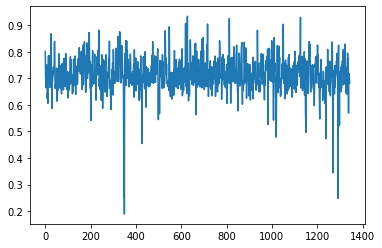

In [217]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [218]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Creation of Model

In [219]:
model = Sequential()

In [220]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [221]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [222]:
warmup_steps = 50

In [223]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [224]:
optimizer = RMSprop(lr=1e-3)

In [225]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [226]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 512)         794112    
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           513       
Total params: 794,625
Trainable params: 794,625
Non-trainable params: 0
_________________________________________________________________


In [227]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [228]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [229]:
callback_tensorboard = TensorBoard(log_dir=".\\23_logs\\",
                                   histogram_freq=0,
                                   write_graph=False)

In [230]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [231]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [232]:
model.fit(x=generator,
          epochs=100,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

  ...
    to  
  ['...']
Train for 100 steps, validate on 1 samples
Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 00001: val_loss improved from inf to 0.00411, saving model to 23_checkpoint.keras
100/100 [==============================] - 28s 282ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 00002: val_loss improved from 0.00411 to 0.00390, saving model to 23_checkpoint.keras
100/100 [==============================] - 27s 275ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0058
Epoch 00003: val_loss improved from 0.00390 to 0.00374, saving model to 23_checkpoint.keras
100/100 [==============================] - 27s 273ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0055
Epoch 00004: val_loss did not improve from 0.00374

Epoch 00004: ReduceL

In [233]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
'str' object has no attribute 'decode'


In [234]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 55ms/sample - loss: 0.0037


In [235]:
print("loss (test-set):", result)

loss (test-set): 0.0036745925899595022


In [236]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [237]:
x_train

array([[ 91.38333333,   0.        , 155.        ],
       [ 92.        ,   1.        , 155.        ],
       [ 93.66666667,   2.        , 155.        ],
       ...,
       [ 89.38333333,  22.        , 236.        ],
       [ 95.16666667,  23.        , 236.        ],
       [ 93.56666667,   0.        , 237.        ]])

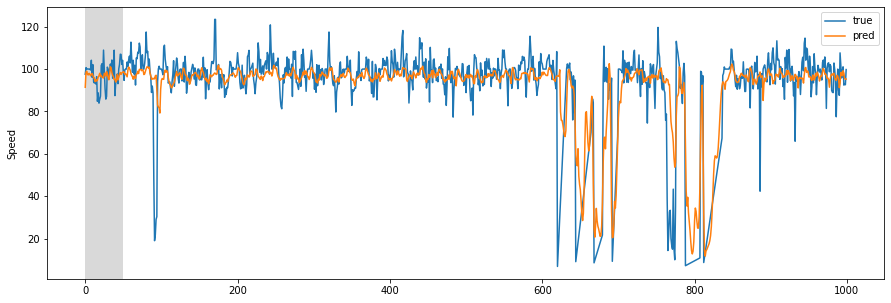

In [238]:
plot_comparison(start_idx=10000, length=1000, train=True)

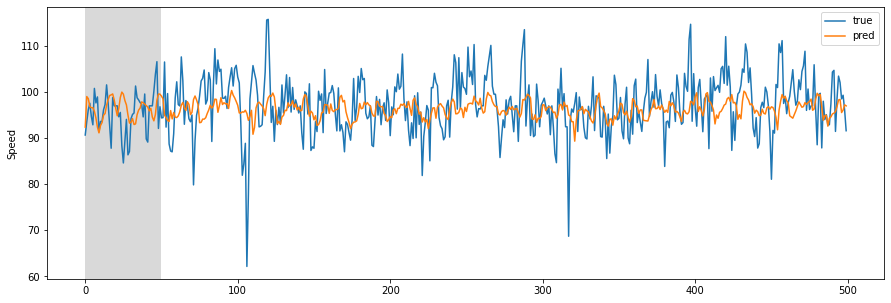

In [239]:
plot_comparison(start_idx=0, length=500, train=False)